In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


In [2]:
import pandas as pd

# Cargando los datos
train_data = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
test_data = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')
sample_submission = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv')

# Mostrando las primeras filas de cada conjunto de datos para explorarlos
(train_data.head(), test_data.head(), sample_submission.head())


(   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
 0   1          60       RL         65.0     8450   Pave   NaN      Reg   
 1   2          20       RL         80.0     9600   Pave   NaN      Reg   
 2   3          60       RL         68.0    11250   Pave   NaN      IR1   
 3   4          70       RL         60.0     9550   Pave   NaN      IR1   
 4   5          60       RL         84.0    14260   Pave   NaN      IR1   
 
   LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
 0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
 1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
 2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
 3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
 4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   
 
   YrSold  SaleType  SaleCondition  SalePrice  
 0   2

# 1. Realizamos el análisis de los datos

## Distribución del "Sales Price"

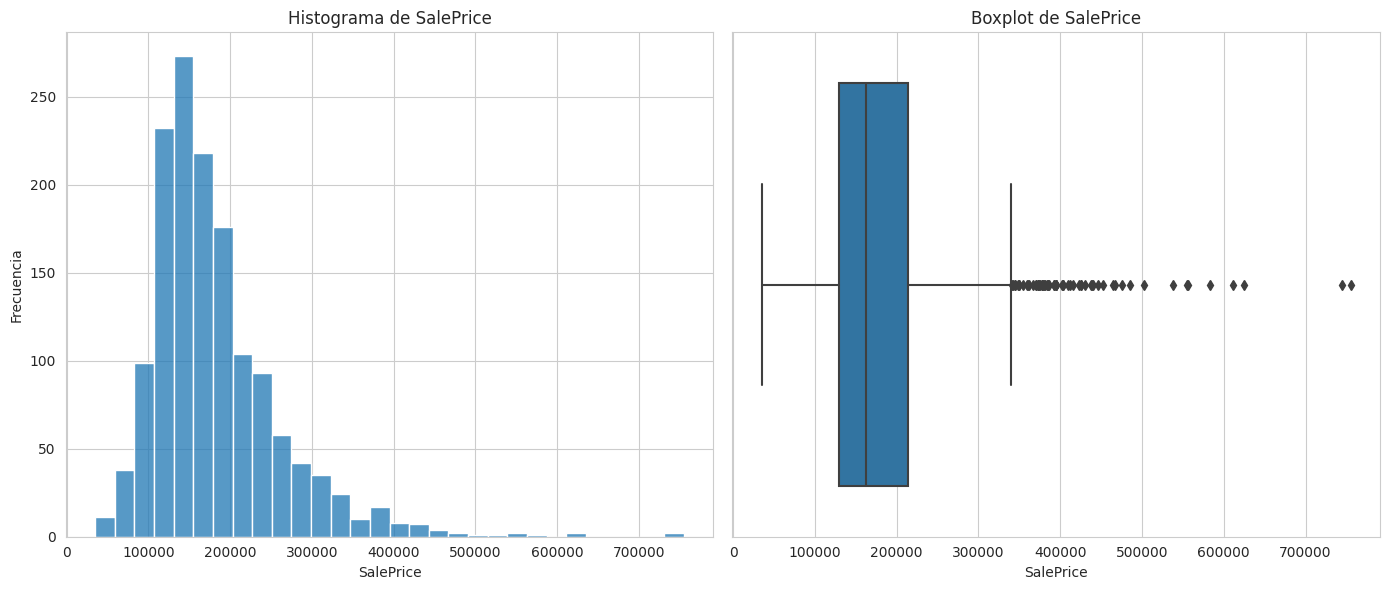

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Configurando el estilo de los gráficos
sns.set_style("whitegrid")

# Creando una figura con dos subgráficos
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Histograma de SalePrice
sns.histplot(train_data['SalePrice'], bins=30, kde=False, ax=ax[0])
ax[0].set_title('Histograma de SalePrice')
ax[0].set_xlabel('SalePrice')
ax[0].set_ylabel('Frecuencia')

# Diagrama de caja de SalePrice
sns.boxplot(x=train_data['SalePrice'], ax=ax[1])
ax[1].set_title('Boxplot de SalePrice')
ax[1].set_xlabel('SalePrice')

# Mostrando los gráficos
plt.tight_layout()
plt.show()


## Correlación con la variable objetivo

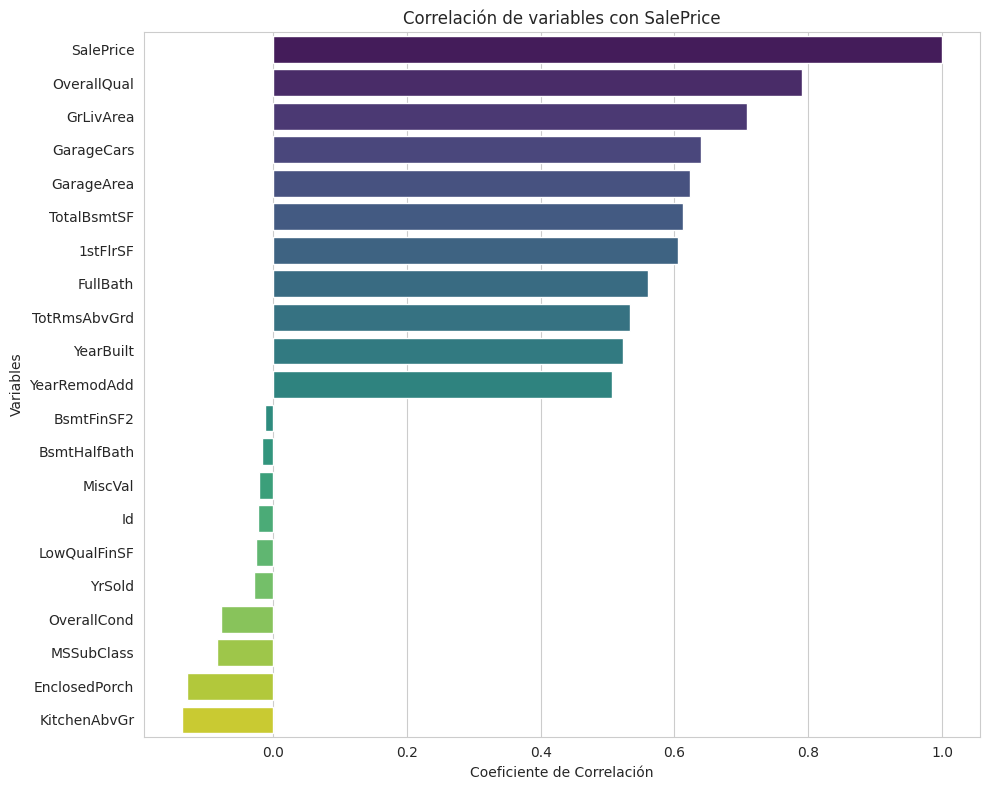

SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
Id              -0.021917
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePrice, dtype: float64

In [4]:
import numpy as np

# Calculando la correlación de todas las variables con 'SalePrice'
correlations = train_data.select_dtypes(include=[np.number]).corr()['SalePrice'].sort_values(ascending=False)

# Seleccionando las 10 variables con mayor correlación positiva y las 10 con mayor correlación negativa
top_corr = pd.concat([correlations.head(11), correlations.tail(10)])

# Creando una figura para visualizar las correlaciones
plt.figure(figsize=(10, 8))

# Creando un gráfico de barras para las correlaciones
sns.barplot(x=top_corr.values, y=top_corr.index, palette="viridis")

# Título y etiquetas
plt.title('Correlación de variables con SalePrice')
plt.xlabel('Coeficiente de Correlación')
plt.ylabel('Variables')

# Mostrando el gráfico
plt.tight_layout()
plt.show()

# Retornando las variables con mayor correlación para referencia
top_corr


### Análisis con algunas variables correlacionadas:
    OverallQual
    GrLivArea
    GarageCars
    TotalBsmtSF
    1stFlrSF

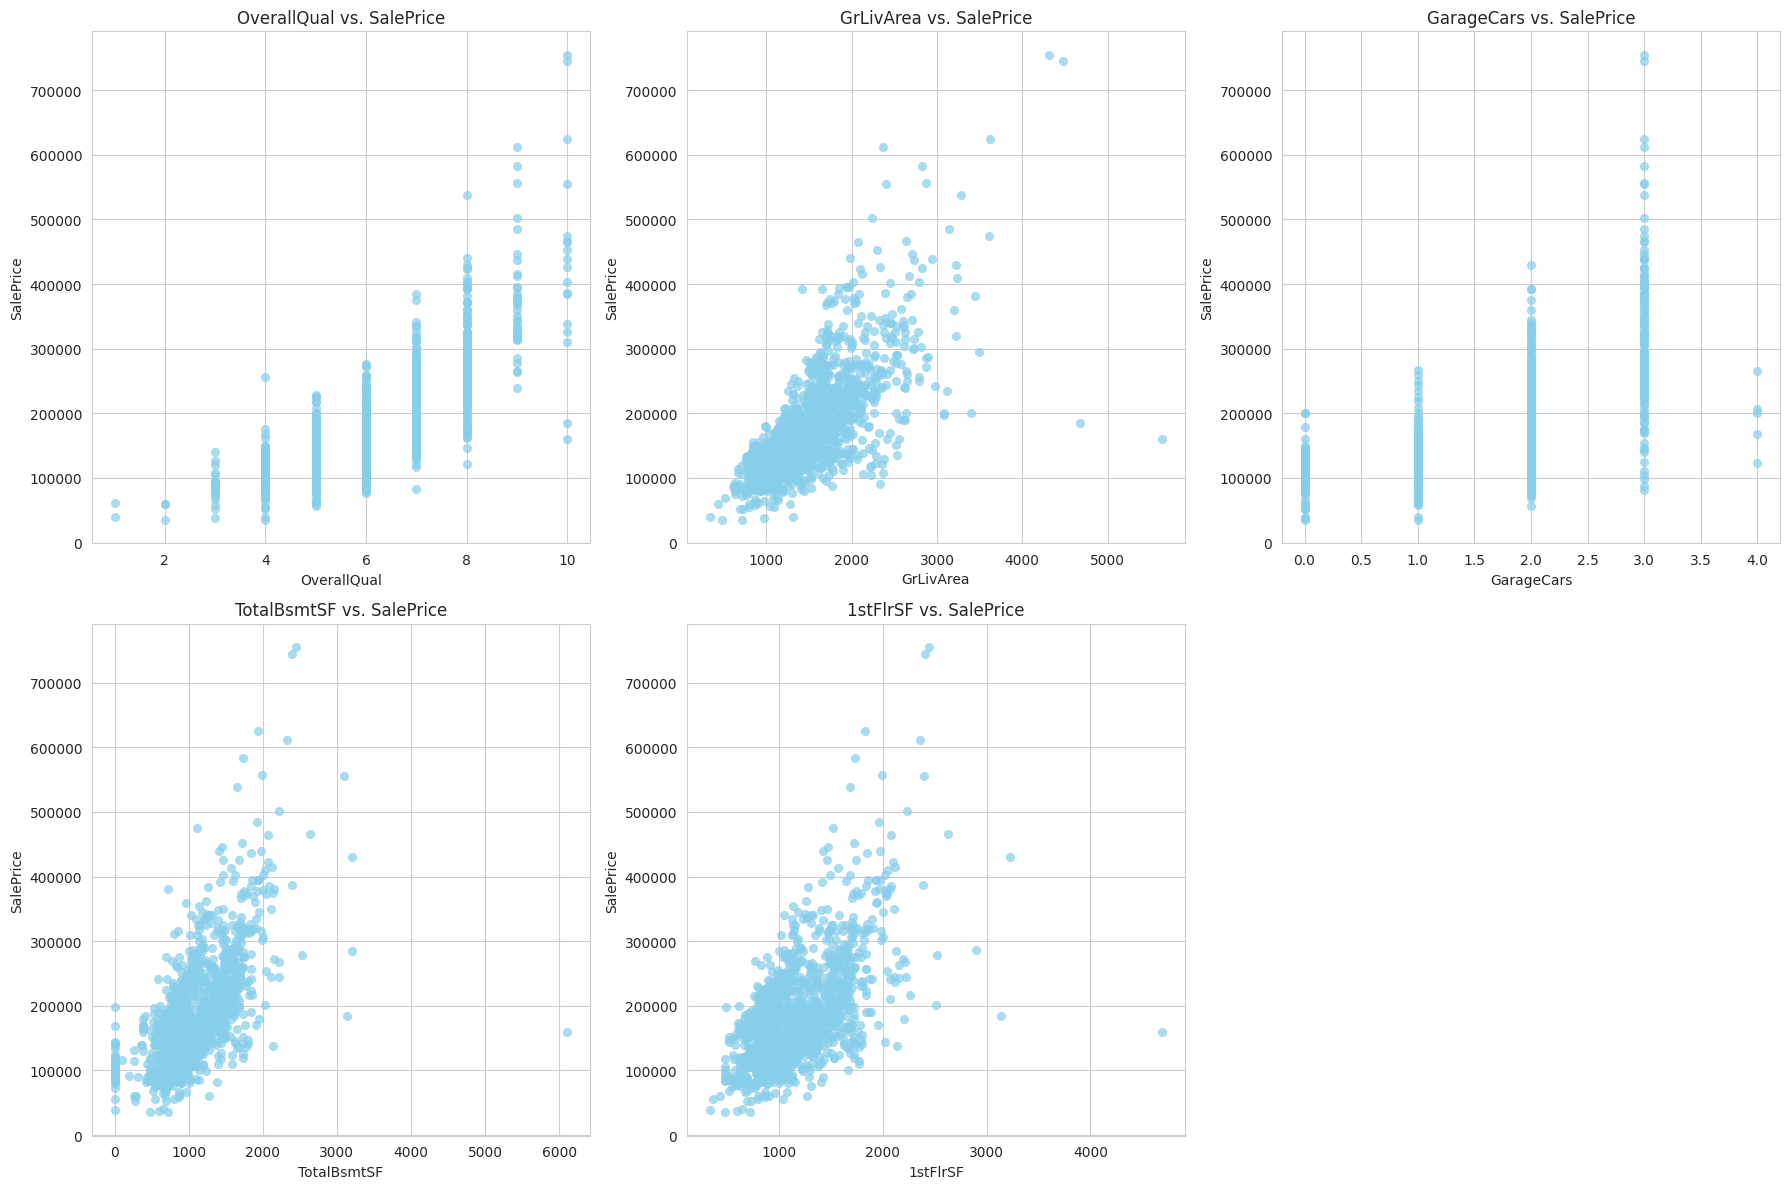

In [5]:
# Creando una figura con varios subgráficos
fig, ax = plt.subplots(2, 3, figsize=(18, 12))
ax = ax.flatten()

# Variables para visualizar
variables_to_plot = ['OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', '1stFlrSF']

# Creando gráficos de dispersión para cada variable en relación con 'SalePrice'
for i, var in enumerate(variables_to_plot):
    sns.scatterplot(x=var, y='SalePrice', data=train_data, ax=ax[i], color='skyblue', edgecolor=None, alpha=0.7)
    ax[i].set_title(f'{var} vs. SalePrice')
    ax[i].set_xlabel(var)
    ax[i].set_ylabel('SalePrice')

# Ajustando el layout y eliminando el último subgráfico vacío
ax[-1].axis('off')
plt.tight_layout()
plt.show()


## Proceder con NAN y valores atípicos

In [6]:
# Calculando la cantidad y porcentaje de valores nulos por columna
missing_values = train_data.isnull().sum()
missing_values = missing_values[missing_values > 0].sort_values(ascending=False)
missing_percentage = (missing_values / len(train_data)) * 100

# Creando un DataFrame para visualizar mejor los resultados
missing_data = pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_percentage})

# Mostrando las primeras 10 variables con más valores nulos
missing_data.head(10)


,Missing Values,Percentage
PoolQC,1453,99.520548
MiscFeature,1406,96.301370
Alley,1369,93.767123
Fence,1179,80.753425
MasVnrType,872,59.726027
FireplaceQu,690,47.260274
LotFrontage,259,17.739726
GarageType,81,5.547945
GarageYrBlt,81,5.547945
GarageFinish,81,5.547945


In [7]:
# 1. Reemplazando NaN con "None" o 0
nan_to_none = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 
               'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 
               'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']
nan_to_zero = ['GarageYrBlt', 'GarageArea', 'GarageCars', 'BsmtFinSF1', 'BsmtFinSF2', 
               'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath']

train_data[nan_to_none] = train_data[nan_to_none].fillna('None')
train_data[nan_to_zero] = train_data[nan_to_zero].fillna(0)

# 2. Imputando valores para LotFrontage usando la mediana
train_data['LotFrontage'] = train_data['LotFrontage'].fillna(train_data['LotFrontage'].median())

# 3. Verificando otras variables con menor cantidad de valores nulos
remaining_nan = train_data.isnull().sum()
remaining_nan = remaining_nan[remaining_nan > 0]

# Verificando si aún hay valores nulos y cuáles son
remaining_nan

MasVnrType    872
MasVnrArea      8
Electrical      1
dtype: int64

In [8]:
# 1. Reemplazando NaN en 'MasVnrType' y 'Electrical'
train_data['MasVnrType'] = train_data['MasVnrType'].fillna('None')
train_data['Electrical'] = train_data['Electrical'].fillna(train_data['Electrical'].mode()[0])

# 2. Reemplazando NaN en 'MasVnrArea'
train_data['MasVnrArea'] = train_data['MasVnrArea'].fillna(0)

# Verificando si aún quedan valores nulos en el conjunto de datos
remaining_nan = train_data.isnull().sum().max()

# Verificando si hemos manejado todos los valores nulos
remaining_nan == 0

True

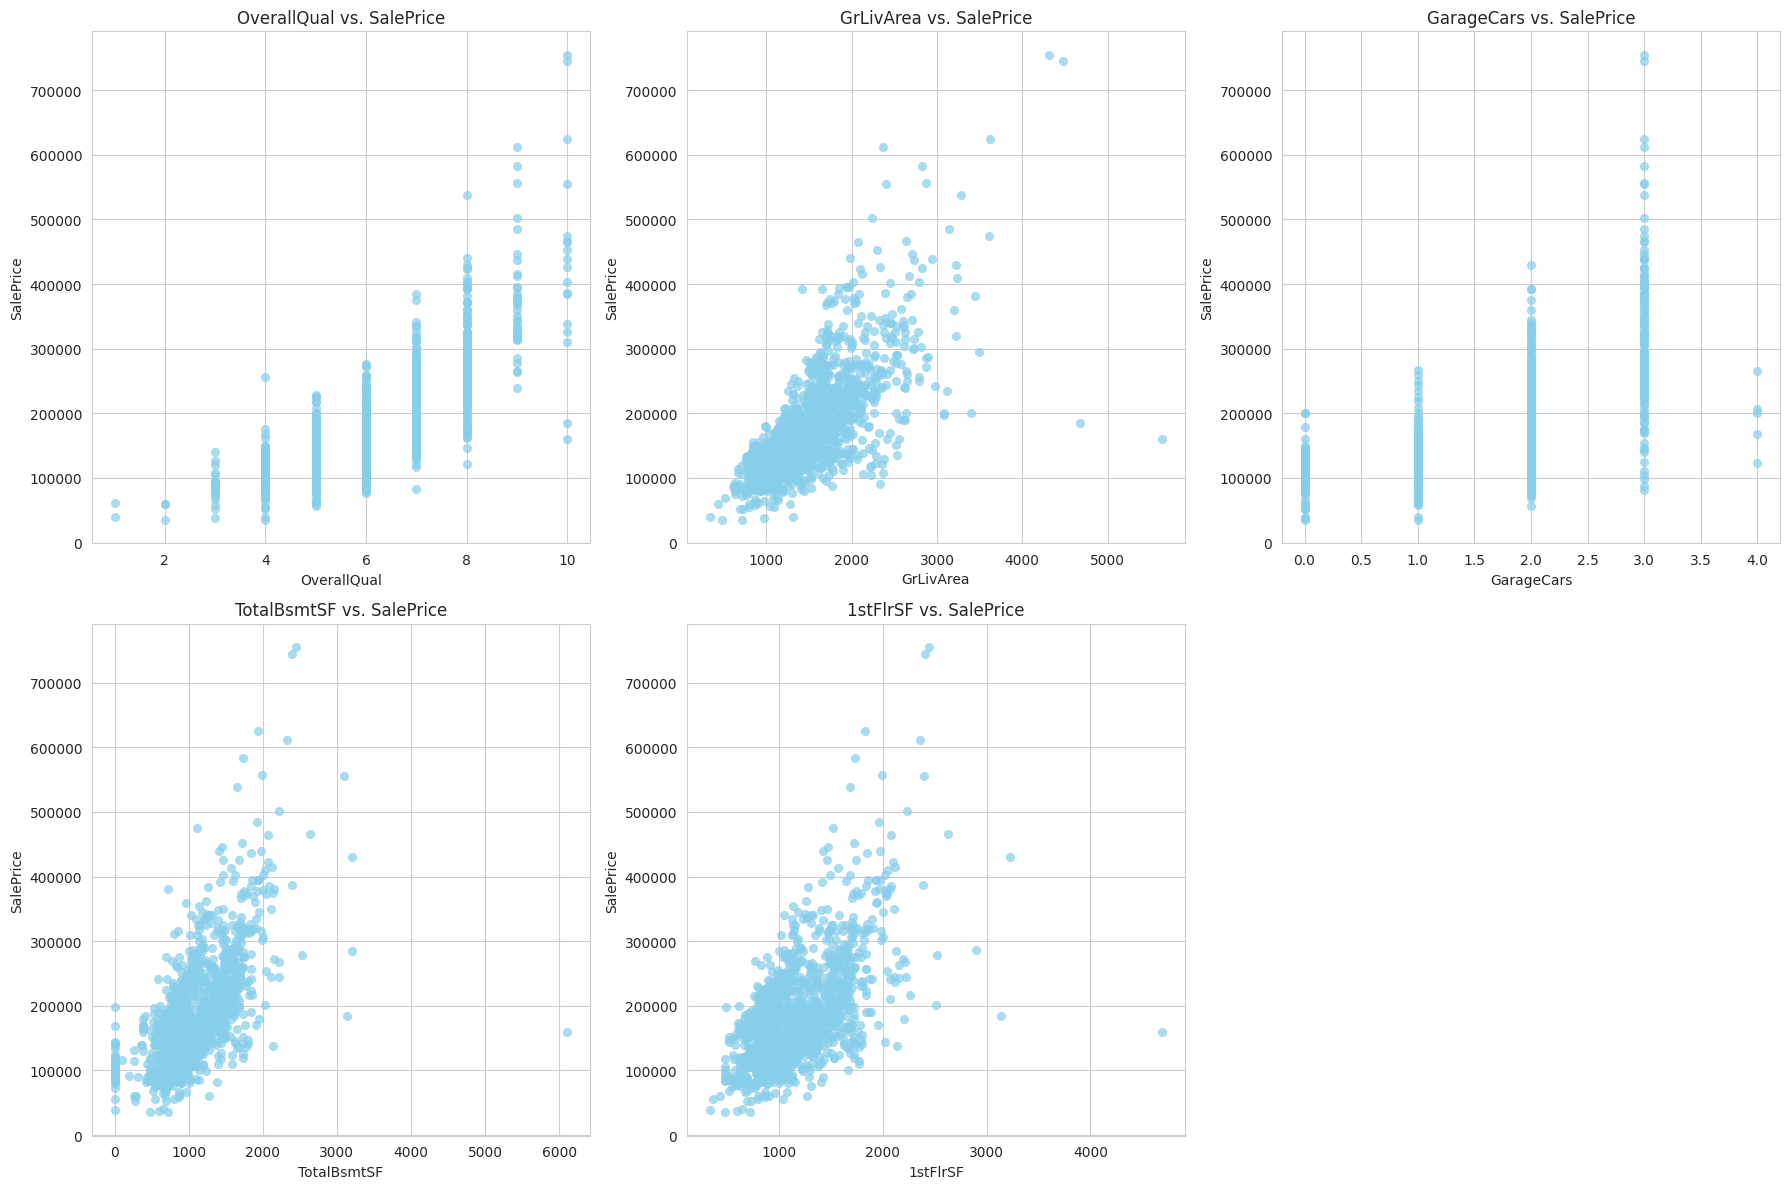

In [9]:
# Creando una figura con varios subgráficos
fig, ax = plt.subplots(2, 3, figsize=(18, 12))
ax = ax.flatten()

# Variables para visualizar
variables_to_plot = ['OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', '1stFlrSF']

# Creando gráficos de dispersión para cada variable en relación con 'SalePrice'
for i, var in enumerate(variables_to_plot):
    sns.scatterplot(x=var, y='SalePrice', data=train_data, ax=ax[i], color='skyblue', edgecolor=None, alpha=0.7)
    ax[i].set_title(f'{var} vs. SalePrice')
    ax[i].set_xlabel(var)
    ax[i].set_ylabel('SalePrice')

# Ajustando el layout y eliminando el último subgráfico vacío
ax[-1].axis('off')
plt.tight_layout()
plt.show()

In [10]:
# Identificando índices de posibles valores atípicos
outliers_idx = []

# Observaciones con grandes GrLivArea pero bajos SalePrice
outliers_idx.extend(train_data[(train_data['GrLivArea'] > 4000) & (train_data['SalePrice'] < 300000)].index.tolist())

# Observaciones con 4 GarageCars pero bajos SalePrice
outliers_idx.extend(train_data[(train_data['GarageCars'] == 4) & (train_data['SalePrice'] < 300000)].index.tolist())

# Observación con extremadamente alta TotalBsmtSF
outliers_idx.extend(train_data[train_data['TotalBsmtSF'] > 6000].index.tolist())

# Eliminando valores atípicos del conjunto de datos
train_data_cleaned = train_data.drop(index=outliers_idx).reset_index(drop=True)

# Verificando las dimensiones del nuevo conjunto de datos
train_data.shape, train_data_cleaned.shape

((1460, 81), (1453, 81))

# 2. Preparación de datos

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Definiendo columnas numéricas y categóricas
numeric_cols = train_data_cleaned.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = train_data_cleaned.select_dtypes(include=['object']).columns.tolist()

# Eliminando la variable objetivo 'SalePrice' de las columnas numéricas
numeric_cols.remove('SalePrice')

# Preparando los transformers para las variables numéricas y categóricas
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')), # Imputer - en caso de que haya valores faltantes
    ('scaler', StandardScaler()) # Estandarizador
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # Imputer
    ('onehot', OneHotEncoder(handle_unknown='ignore')) # OneHotEncoder
])

# Combinando ambos transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Dividiendo en X e y
X = train_data_cleaned.drop(columns='SalePrice')
y = train_data_cleaned['SalePrice']

# Dividiendo en conjuntos de entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)

# Verificando las dimensiones de los conjuntos de datos
(X_train.shape, X_val.shape), (y_train.shape, y_val.shape)


(((1162, 80), (291, 80)), ((1162,), (291,)))

# 3. MODELADO

In [12]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import make_pipeline
import numpy as np

# Creando y entrenando el pipeline
model = make_pipeline(preprocessor, LinearRegression())
model.fit(X_train, y_train)

# Predicciones
train_preds = model.predict(X_train)
val_preds = model.predict(X_val)

# Evaluación del modelo
train_rmse = np.sqrt(mean_squared_error(y_train, train_preds))
val_rmse = np.sqrt(mean_squared_error(y_val, val_preds))
train_r2 = r2_score(y_train, train_preds)
val_r2 = r2_score(y_val, val_preds)

(train_rmse, train_r2), (val_rmse, val_r2)

((19025.422514460908, 0.9434080227212286),
 (79472.1636536435, -0.04398284889623438))

In [13]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Creando diferentes modelos para probar
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor(),
    'Gradient Boosting': GradientBoostingRegressor()
}

# Evaluando cada modelo
results = {}

for model_name, model in models.items():
    # Creando y entrenando el pipeline
    pipeline = make_pipeline(preprocessor, model)
    pipeline.fit(X_train, y_train)
    
    # Predicciones y evaluación
    val_preds = pipeline.predict(X_val)
    val_rmse = np.sqrt(mean_squared_error(y_val, val_preds))
    val_r2 = r2_score(y_val, val_preds)
    
    # Almacenando los resultados
    results[model_name] = {'RMSE': val_rmse, 'R2': val_r2}

# Convertir los resultados en un DataFrame para una mejor visualización
results_df = pd.DataFrame(results).T

results_df.sort_values(by='RMSE', ascending=True)


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:592: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 212952794573.79935, tolerance: 743224265.6625473
  model = cd_fast.sparse_enet_coordinate_descent(


,RMSE,R2
Ridge Regression,21155.891059,0.926018
Gradient Boosting,21553.292803,0.923212
Random Forest,23994.219805,0.904835
Lasso Regression,30092.316372,0.850316
Decision Tree,36806.903850,0.776065
Linear Regression,79472.163654,-0.043983


In [14]:
# Asegurándonos de que el modelo esté entrenado con todos los datos disponibles
final_model = make_pipeline(preprocessor, Ridge())
final_model.fit(X, y)

# Realizando predicciones en el conjunto de datos de prueba
test_preds = final_model.predict(test_data)

# Creando un DataFrame para las predicciones
predictions_df = pd.DataFrame({'Id': test_data['Id'], 'SalePrice': test_preds})

# Visualizando las primeras predicciones
predictions_df.head()


,Id,SalePrice
0,1461,110148.272908
1,1462,152046.448279
2,1463,187817.177520
3,1464,195153.791726
4,1465,204366.987587


In [15]:
# Guardando las predicciones en un archivo CSV
predictions_filepath = 'predictions.csv'
predictions_df.to_csv(predictions_filepath, index=False)

# Proporcionando el enlace para la descarga
predictions_filepath

'predictions.csv'